In [1]:
# from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py
import scipy.stats
from tqdm import tqdm
import pdb
import os
from matplotlib.backends.backend_pdf import PdfPages
import sklearn.preprocessing

# behav_mat = loadmat('ms.mat');
# read calcium data
with h5py.File('ms.mat', 'r') as f:
    ms_mat = f['ms']
    FiltTraces = np.array(ms_mat['FiltTraces'])
    RawTraces = np.array(ms_mat['RawTraces'])
    DeconvSignal = np.array(ms_mat['DeconvSignals'])
    ms_time = np.array(ms_mat['time'])[0,]
# read behav data
with open('maze1.pkl', 'rb') as handle:
    graph = pickle.load(handle)
# time in seconds
with open('behav_decision.pkl', 'rb') as handle:
    correct_time, wrong_time, correct_time_percentage, decision_rate,_ = pickle.load(handle)
with open('behav_processed.pkl', 'rb') as handle:
    behav_time_original, behav_nodes_interpolated, behav_dir = pickle.load(handle)


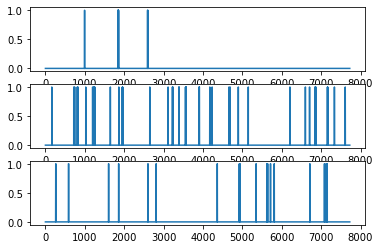

In [2]:
# remove no behav recording period
behav_mask = (ms_time>=behav_time_original[0]) & (ms_time<behav_time_original[-1])
FiltTraces_behav = FiltTraces[:,behav_mask]
RawTraces_behav = RawTraces[:,behav_mask]
DeconvSignal_behav = DeconvSignal[:,behav_mask]
ms_time_behav = ms_time[behav_mask]

# plot spike data
deconv_sd = np.std(DeconvSignal_behav, axis = 1) * 3
Spikes = np.where(DeconvSignal_behav>np.repeat(deconv_sd[:,np.newaxis], DeconvSignal_behav.shape[1],1), 1, 0)
plt.subplot(311)
plt.plot(Spikes[1,:])
plt.subplot(312)
plt.plot(Spikes[2,:])
plt.subplot(313)
plt.plot(Spikes[3,:])

In [3]:
class Cell:
    """A cell in the maze.

    A maze "Cell" is a point in the grid which may be surrounded by walls to
    the north, east, south or west.

    """

    # A wall separates a pair of cells in the N-S or W-E directions.
    wall_pairs = {'N': 'S', 'S': 'N', 'E': 'W', 'W': 'E'}

    def __init__(self, x, y):
        """Initialize the cell at (x,y). At first it is surrounded by walls."""

        self.x, self.y = x, y
        self.walls = {'N': True, 'S': True, 'E': True, 'W': True}

    def has_all_walls(self):
        """Does this cell still have all its walls?"""

        return all(self.walls.values())

    def knock_down_wall(self, other, wall):
        """Knock down the wall between cells self and other."""

        self.walls[wall] = False
        other.walls[Cell.wall_pairs[wall]] = False

        
class Maze:
    """    
    This constructs a maze with a given graph, represented as a grid of cells.
    The maze consists of square cells the width of a corridor.
    Each cell in the maze has an (x,y) location, with x,y = 0,...,n
    y runs top to bottom.
    Each cell is also given a unique integer cell number.
    The present maze consists of straight runs, each run terminates in a branch point or 
    an end point. 
    
    graph: dict, keys-nodes: values-their neighbors
    maze_map: list of Cells
    decision_node: nodes with decision point
    runs: list of list of nodes
    """

    def __init__(self, nx, ny, graph, ix=0, iy=0, start_node = 1, end_node = 144):
        """Initialize the maze grid.
        The maze consists of nx x ny cells and will be constructed starting
        at the cell indexed at (ix, iy).

        """
        self.nx, self.ny = nx, ny
        self.ix, self.iy = ix, iy
        self.cell_num = nx * ny
        self.graph = graph
        self.maze_map = [[Cell(x, y) for y in range(ny)] for x in range(nx)]
        # Direction: neightbor - current
        self.to_direction = {(-1, 0): 'W',
                 (1, 0): 'E',
                 (0, 1):'S',
                 (0, -1): 'N'}
        self.is_bidirectional = self.check_bidirectional(graph) # check if the graph is bidirectional
        if self.is_bidirectional:
            self.make_maze() # knock down walls according to graph
            self.repeated_parents = set()
            self.decision_nodes = []
            self.runs = self.get_run_from_current(start_node, graph)
            self.shortest_path = self.BFS_SP(graph, start_node, end_node)
            self.run_levels = self.get_levels_for_runs()
            self.cell_levels = self.get_levels_for_cells()
            
    def cell_at(self, x, y):
        """Return the Cell object at (x,y)."""
        return self.maze_map[x][y]
    
    def idx_to_loc(self, idx):
        # convert index to location (x,y), note: location start from 0
        cell_w = idx % self.nx
        cell_h = idx // self.ny
        return cell_w, cell_h
    
    def loc_to_idx(self, cell_w, cell_h):
        # convert location (x,y) to index
        idx = cell_w * self.nx + cell_h +1
        return idx
    
    def check_bidirectional(self, graph):
        # check if the maze is bidirectional
        is_bidirectional = True
        for node in graph.keys():
            child_nodes = graph[node]
            for child in child_nodes:
                if not node in graph[child]:
                    print("Warning: node " + str(node) + " not in node " + str(child))
                    is_bidirectional = False
        if is_bidirectional:
            print("The maze is bidirectional, Ye!")
        else:
            print("Something is wrong, check log")
        return is_bidirectional

    def get_run_from_current(self, current_node, graph, runs = []):
        # get all runs from current node. Runs are defined as independent decision unit consisting a group of nodes
        # return runs
        done = False
        run = [current_node] # put current node in run
        self.repeated_parents.add(current_node) # add current node to repeated node (each node only belongs to one run)
        children_node = [value for value in graph[current_node] if not value in self.repeated_parents] # delete repeated children

        while not done:
            if len(children_node) >= 2: # child nodes >=2, decision point
                print("Node " + str(current_node) + " is Decision point")
                self.decision_nodes.append(current_node)
                runs.append(run) # 
                # b.set_trace()
                for child in children_node:
                    runs = self.get_run_from_current(child, graph, runs = runs)
                done = True
            elif len(children_node) == 0: # leaf node
                print("Node " + str(current_node) + " is Leaf node")
                runs.append(run)
                done = True
            else:
                current_node = children_node[0]
                # print(current_node)
                self.repeated_parents.add(current_node)
                run.append(current_node)
                # pdb.set_trace()
                children_node = [value for value in graph[current_node] if not value in self.repeated_parents] # parent will not be children's children
        return runs
    
    def get_levels_for_runs(self):
        # calculate levels for all runs
        # a level consists a group of cells separated by decision points
        level_seq = list(range(len(self.decision_nodes)))
        run_level = [0]*len(self.runs)
        for i in range(len(self.runs)):
            # if runs are on shortest path, the last node should be decision nodes and determine its level
            if self.runs[i][-1] in self.decision_nodes:
                run_level[i] = level_seq[self.decision_nodes.index(self.runs[i][-1])]
            # if runs are not on shortest path, the neighbor of the first node should be decision nodes and determine its level
            else:
                first_neighbors = self.graph[self.runs[i][0]]
                decision_node_ind = [ind for ind, val in enumerate(first_neighbors) if val in self.shortest_path][0]
                decision_node_neighbor = first_neighbors[decision_node_ind]
                run_level[i] = level_seq[self.decision_nodes.index(decision_node_neighbor)]
        return run_level  

    def get_levels_for_cells(self):
        cell_levels = [0]*self.cell_num
        # calculate levels for all cells
        for i_run in range(len(self.runs)):
            run_level = self.run_levels[i_run]
            for i_cell in self.runs[i_run]:
                cell_levels[i_cell-1] = run_level
        return cell_levels
        
    # Function to find the shortest
    # path between two nodes of a graph
    def BFS_SP(self,graph, start, goal):
        explored = []

        # Queue for traversing the
        # graph in the BFS
        queue = [[start]]

        # If the desired node is
        # reached
        if start == goal:
            print("Same Node")
            return(None)

        # Loop to traverse the graph
        # with the help of the queue
        while queue:
            path = queue.pop(0)
            node = path[-1]

            # Condition to check if the
            # current node is not visited
            if node not in explored:
                neighbours = graph[node]

                # Loop to iterate over the
                # neighbours of the node
                for neighbour in neighbours:
                    new_path = list(path)
                    new_path.append(neighbour)
                    queue.append(new_path)

                    # Condition to check if the
                    # neighbour node is the goal
                    if neighbour == goal:
                        print("Shortest path = ", *new_path)
                        return(new_path)
                explored.append(node)

        # Condition when the nodes
        # are not connected
        print("So sorry, but a connecting"\
                    "path doesn't exist :(")
        return(None)
    
    def __str__(self):
        """Return a (crude) string representation of the maze."""

        maze_rows = ['-' * self.nx * 2]
        for y in range(self.ny):
            maze_row = ['|']
            for x in range(self.nx):
                if self.maze_map[x][y].walls['E']:
                    maze_row.append(' |')
                else:
                    maze_row.append('  ')
            maze_rows.append(''.join(maze_row))
            maze_row = ['|']
            for x in range(self.nx):
                if self.maze_map[x][y].walls['S']:
                    maze_row.append('-+')
                else:
                    maze_row.append(' +')
            maze_rows.append(''.join(maze_row))
        return '\n'.join(maze_rows)
    
    def maze_plot(self, axes = None):
        # plot maze with matplotlib.plot
        aspect_ratio = self.nx / self.ny
        # Pad the maze all around by this amount.
        padding = 0.05
        # Height and width of the maze image (excluding padding), in pixels
        height = 6
        width = int(height * aspect_ratio)
        # Scaling factors mapping maze coordinates to image coordinates
        scy, scx = height / self.ny, width / self.nx
        # Write the SVG image file for maze
        # SVG preamble and styles.
        if axes == None:
            fig = plt.figure(figsize=[(height + 2 * padding), (width + 2 * padding)])
            axes = plt.gca()
            axes.invert_yaxis()
        
        # Draw the "South" and "East" walls of each cell, if present (these
        # are the "North" and "West" walls of a neighbouring cell in
        # general, of course).
        for x in range(self.nx):
            for y in range(self.ny):
                if self.cell_at(x, y).walls['S']:
                    x1, y1, x2, y2 = x * scx, (y + 1) * scy, (x + 1) * scx, (y + 1) * scy
                    axes.plot([x1, x2], [y1, y2], color = "black")
                if self.cell_at(x, y).walls['E']:
                    x1, y1, x2, y2 = (x + 1) * scx, y * scy, (x + 1) * scx, (y + 1) * scy
                    axes.plot([x1, x2], [y1, y2], color = "black")
        # Draw the North and West maze border, which won't have been drawn
        # by the procedure above.
        axes.plot([0, 0], [0, height], color = "black")
        axes.plot([0, width], [0, 0], color = "black")
        return axes
    
    def maze_plot_num(self, axes = None, mode='cells',numcol='blue'):
        '''
        adds numbering to an existing maze plot given by axes
        m: maze
        mode: 'cells','runs','nodes': depending on what gets numbered
        numcol: color of the numbers
        '''
        axes = self.maze_plot(axes)
        # plot maze with matplotlib.plot
        aspect_ratio = self.nx / self.ny
        # Pad the maze all around by this amount.
        padding = 0.05
        # Height and width of the maze image (excluding padding), in pixels
        height = 6
        width = int(height * aspect_ratio)
        # Scaling factors mapping maze coordinates to image coordinates
        scy, scx = height / self.ny, width / self.nx

        if mode=='nodes':
            for j,r in enumerate(self.runs):
                x, y = self.idx_to_loc(r[-1]-1)
                plt.text((x+0.25)*scx, (y+0.65)*scy, '{:d}'.format(j+1),color=numcol) # number the ends of a run    
        
        if mode=='cells':
            for j in range(self.nx * self.ny):
                x, y = self.idx_to_loc(j)
                plt.text((x+0.25)*scx, (y+0.65)*scy, '{:d}'.format(j+1),color=numcol) # number the cells    
        
        if mode=='decisions':
            for j,d in enumerate(self.decision_nodes):
                x, y = self.idx_to_loc(d-1)
                plt.text((x+0.25)*scx, (y+0.65)*scy, '{:d}'.format(j+1),color=numcol) # number the cells    

    
    def write_svg(self, filename):
        """Write an SVG image of the maze to filename."""

        aspect_ratio = self.nx / self.ny
        # Pad the maze all around by this amount.
        padding = 10
        # Height and width of the maze image (excluding padding), in pixels
        height = 500
        width = int(height * aspect_ratio)
        # Scaling factors mapping maze coordinates to image coordinates
        scy, scx = height / self.ny, width / self.nx

        def write_wall(ww_f, ww_x1, ww_y1, ww_x2, ww_y2):
            """Write a single wall to the SVG image file handle f."""

            print('<line x1="{}" y1="{}" x2="{}" y2="{}"/>'
                  .format(ww_x1, ww_y1, ww_x2, ww_y2), file=ww_f)

        # Write the SVG image file for maze
        with open(filename, 'w') as f:
            # SVG preamble and styles.
            print('<?xml version="1.0" encoding="utf-8"?>', file=f)
            print('<svg xmlns="http://www.w3.org/2000/svg"', file=f)
            print('    xmlns:xlink="http://www.w3.org/1999/xlink"', file=f)
            print('    width="{:d}" height="{:d}" viewBox="{} {} {} {}">'
                  .format(width + 2 * padding, height + 2 * padding,
                          -padding, -padding, width + 2 * padding, height + 2 * padding),
                  file=f)
            print('<defs>\n<style type="text/css"><![CDATA[', file=f)
            print('line {', file=f)
            print('    stroke: #000000;\n    stroke-linecap: square;', file=f)
            print('    stroke-width: 5;\n}', file=f)
            print(']]></style>\n</defs>', file=f)
            # Draw the "South" and "East" walls of each cell, if present (these
            # are the "North" and "West" walls of a neighbouring cell in
            # general, of course).
            for x in range(self.nx):
                for y in range(self.ny):
                    if self.cell_at(x, y).walls['S']:
                        x1, y1, x2, y2 = x * scx, (y + 1) * scy, (x + 1) * scx, (y + 1) * scy
                        write_wall(f, x1, y1, x2, y2)
                    if self.cell_at(x, y).walls['E']:
                        x1, y1, x2, y2 = (x + 1) * scx, y * scy, (x + 1) * scx, (y + 1) * scy
                        write_wall(f, x1, y1, x2, y2)
            # Draw the North and West maze border, which won't have been drawn
            # by the procedure above.
            print('<line x1="0" y1="0" x2="{}" y2="0"/>'.format(width), file=f)
            print('<line x1="0" y1="0" x2="0" y2="{}"/>'.format(height), file=f)
            print('</svg>', file=f)

    def make_maze(self):
        ##  Knock down walls according to graph
        ## Note: location (x, y) start from 0, while index (idx) start from 1, BE CAREFUL!
        # Total number of cells.
        n_total = self.nx * self.ny
        for i in range(n_total):
            current_idx = i+1
            current_x, current_y = self.idx_to_loc(current_idx-1)
            current_cell = self.cell_at(current_x, current_y)
            neighbor_idxs = self.graph[current_idx]
            for neighbor_idx in neighbor_idxs:
                #pdb.set_trace()
                neighbor_x, neighbor_y = self.idx_to_loc(neighbor_idx-1)
                next_cell = self.cell_at(neighbor_x, neighbor_y)
                # print((current_idx, neighbor_idx) )

                # pdb.set_trace()
                diff_loc = (neighbor_x-current_x, neighbor_y-current_y)
                neighbor_dir = self.to_direction[diff_loc]
                current_cell.knock_down_wall(next_cell, neighbor_dir)
               
            

In [4]:
# initialze maze object
start_node = 1
end_node = 144
nx = 12
ny = 12
total_bin = nx*ny
test_maze = Maze(nx, ny, graph)
new_maze = test_maze.make_maze()
shortest_path = test_maze.BFS_SP(graph, start_node, end_node)
# behav_bins = test_maze.idx_to_loc(behav_nodes_interpolated-1) # start from 0

The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Leaf node
Node 25 is Leaf node
Shortest path =  1 13 14 26 27 15 3 4 5 6 18 17 29 30 31 19 20 21 9 10 11 12 24 23 22 34 33 32 44 45 46 47 48 60 59 58 57 56 68 69 70 71 72 84 8

In [5]:
# spike per bin
spike_nodes = np.zeros_like(Spikes[0,:])
for i in range(0, len(spike_nodes)):
    if ms_time_behav[i] < behav_time_original[0]:
        spike_nodes[i] = start_node;
    else:
        match_index = np.where(behav_time_original <= ms_time_behav[i])[0][-1]
        spike_nodes[i] = behav_nodes_interpolated[match_index]
spike_bins = test_maze.idx_to_loc(spike_nodes-1)

In [8]:
# occupancy map, in ms
# Duration for each (X,Y) sample (clipped to maxGap)
maxGap = 100
stay_time = np.append(np.ediff1d(ms_time_behav),0)
stay_time[stay_time>maxGap] = maxGap
_nbins = total_bin
_coords_range = [0, _nbins +0.0001 ]
occu_time, xbin_edges, bin_numbers = scipy.stats.binned_statistic(
        spike_nodes,
        stay_time,
        bins=_nbins,
        statistic="sum",
        range=_coords_range)

assert((bin_numbers == spike_nodes).all())
minimum_occu_thres = 50 # ms, occupancy time less than the threshold are set to NAN, preventing large spike rate
occu_time[occu_time<minimum_occu_thres] = np.nan

In [19]:
### sum rate map (for first neuron)
_nbins = total_bin
_coords_range = [0, _nbins +0.0001 ]
spikes = Spikes[0,:]

# spike_map: total spikes per nodes
spike_freq, xbin_edges, bin_numbers = scipy.stats.binned_statistic(
        spike_nodes,
        spikes,
        bins=_nbins,
        statistic="sum",
        range=_coords_range)

rate_map = spike_freq/(occu_time/1000+ 1E-6) # ratemap: spike_map / occupancy_map
assert((bin_numbers == spike_nodes).all())


In [20]:
# rate map (for all neuron)
n_neuron = Spikes.shape[0]
spike_freq_all = np.zeros([n_neuron,total_bin])
rate_map_all =  np.zeros_like(spike_freq_all)
for i in range(n_neuron):
    spike_freq_all[i,] ,_ ,_= scipy.stats.binned_statistic(
        spike_nodes,
        Spikes[i,:],
        bins=_nbins,
        statistic="sum",
        range=_coords_range)
    rate_map_all[i,] = spike_freq_all[i,]/(occu_time/1000+ 1E-9)

In [17]:
# spatial information (for one neuron) 
# see DOI: 10.1126/science.aav9199
t_total = np.nansum(occu_time)/1000 # total time of trial
t_nodes_frac = occu_time/1000/ (t_total+ 1E-6)   # time spent in ith bin/total session time

def calc_SI(spikes, rate_map, t_total, t_nodes_frac):
    mean_rate = sum(spikes)/t_total # mean firing rate
    logArg = rate_map / mean_rate;
    logArg[logArg == 0] = 1; # keep argument in log non-zero

    IC = np.nansum(t_nodes_frac * rate_map * np.log2(logArg)) # information content
    SI = IC / mean_rate; # spatial information (bits/spike)
    return(SI)

SI = calc_SI(spikes=spikes, rate_map=rate_map, t_total=t_total, t_nodes_frac=t_nodes_frac)

# shuffle information for 1000 times
shuffle_n = 1000
SI_rand = np.zeros(shuffle_n)
for i in range(shuffle_n):
    shuffle_tmp = np.random.randint(Spikes.shape[1])
    spikes_rand = np.roll(spikes, shuffle_tmp)
    spike_freq_rand, _, _ = scipy.stats.binned_statistic(
        spike_nodes,
        spikes_rand,
        bins=_nbins,
        statistic="sum",
        range=_coords_range)
    rate_map_rand = spike_freq_rand/(occu_time/1000+ 1E-6)    
    SI_rand[i] = calc_SI(spikes = spikes_rand, rate_map = rate_map_rand, t_total = t_total, t_nodes_frac=t_nodes_frac)
SI_thres = np.percentile(SI_rand, 95)
if SI<SI_thres:
    print("This cell is rejected by 95% threshold, i.e. not place cell." )
else:
    print("Ye! This cell is a place cell!")

This cell is rejected by 95% threshold, i.e. not place cell.


In [18]:
# spatial information (all neurons)
SI_all = np.zeros(n_neuron)
is_placecell_shift = np.zeros(n_neuron)

def shuffle_test_shift(SI, spikes, spike_nodes, occu_time, _coords_range, _nbins = 144, shuffle_n = 1000):
    SI_rand = np.zeros(shuffle_n)
    t_total = np.nansum(occu_time)/1000
    t_nodes_frac = occu_time/1000/ (t_total+ 1E-6)
    for i in range(shuffle_n):
        shuffle_tmp = np.random.randint(spikes.shape[0])
        spikes_rand = np.roll(spikes, shuffle_tmp)
        spike_freq_rand, _, _ = scipy.stats.binned_statistic(
            spike_nodes,
            spikes_rand,
            bins=_nbins,
            statistic="sum",
            range=_coords_range)
        rate_map_rand = spike_freq_rand/(occu_time/1000+ 1E-6)    
        SI_rand[i] = calc_SI(spikes = spikes_rand, rate_map = rate_map_rand, t_total = t_total, t_nodes_frac=t_nodes_frac)
    is_placecell = SI > np.percentile(SI_rand, 95)
    return is_placecell

for i in tqdm(range(n_neuron)):
    SI_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_all[i,], t_total=t_total, t_nodes_frac=t_nodes_frac)
    is_placecell_shift[i] = shuffle_test_shift(SI = SI_all[i], spikes = Spikes[i,], spike_nodes=spike_nodes, occu_time=occu_time, _coords_range=_coords_range)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:53<00:00,  1.59it/s]


In [19]:
# spatial information (all neurons)
# Shuffle all random
SI_all = np.zeros(n_neuron)
is_placecell_all = np.zeros(n_neuron)

def shuffle_test(SI, spikes, spike_nodes, occu_time, _coords_range, _nbins = 144, shuffle_n = 1000):
    SI_rand = np.zeros(shuffle_n)
    t_total = np.nansum(occu_time)/1000
    t_nodes_frac = occu_time/1000/ (t_total+ 1E-6)
    sum_spikes = np.sum(spikes)
    for i in range(shuffle_n):
        spikes_rand = np.zeros_like(spikes)
        shuffle_spike_ind = np.random.randint(spikes.shape[0], size = sum_spikes)
        
        spikes_rand[shuffle_spike_ind] = 1
        spike_freq_rand, _, _ = scipy.stats.binned_statistic(
            spike_nodes,
            spikes_rand,
            bins=_nbins,
            statistic="sum",
            range=_coords_range)
        rate_map_rand = spike_freq_rand/(occu_time/1000+ 1E-6)    
        SI_rand[i] = calc_SI(spikes = spikes_rand, rate_map = rate_map_rand, t_total = t_total, t_nodes_frac=t_nodes_frac)
    is_placecell = SI > np.percentile(SI_rand, 95)
    return is_placecell

for i in tqdm(range(n_neuron)):
    SI_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_all[i,], t_total=t_total, t_nodes_frac=t_nodes_frac)
    is_placecell_all[i] = shuffle_test(SI = SI_all[i], spikes = Spikes[i,], spike_nodes=spike_nodes, occu_time=occu_time, _coords_range=_coords_range)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:53<00:00,  1.59it/s]


In [49]:
# spatial information (all neurons)
# Shuffle ISI: DOI: 10.1523/JNEUROSCI.19-21-09497.1999
SI_all = np.zeros(n_neuron)
is_placecell_isi = np.zeros(n_neuron)

def shuffle_test_isi(SI, spikes, spike_nodes, occu_time, _coords_range, _nbins = 144, shuffle_n = 1000):
    SI_rand = np.zeros(shuffle_n)
    t_total = np.nansum(occu_time)/1000
    t_nodes_frac = occu_time/1000/ (t_total+ 1E-6) 
    spike_ind = np.where(spikes==1)[0] # spike index
    isi = np.append(spike_ind[0], np.ediff1d(spike_ind)) # get interspike interval

    for i in range(shuffle_n):
        shuffle_isi = np.random.choice(isi, size = len(isi), replace = False) # shuffle interspike interval
        shuffle_spike_ind = np.cumsum(shuffle_isi) # shuffled spike index

        spikes_rand = np.zeros_like(spikes)        
        spikes_rand[shuffle_spike_ind] = 1
        spike_freq_rand, _, _ = scipy.stats.binned_statistic(
            spike_nodes,
            spikes_rand,
            bins=_nbins,
            statistic="sum",
            range=_coords_range)
        rate_map_rand = spike_freq_rand/(occu_time/1000+ 1E-6)    
        SI_rand[i] = calc_SI(spikes = spikes_rand, rate_map = rate_map_rand, t_total = t_total, t_nodes_frac=t_nodes_frac)
    is_placecell = SI > np.percentile(SI_rand, 95)
    return is_placecell

for i in tqdm(range(n_neuron)):
    SI_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_all[i,], t_total=t_total, t_nodes_frac=t_nodes_frac)
    is_placecell_isi[i] = shuffle_test_isi(SI = SI_all[i], spikes = Spikes[i,], spike_nodes=spike_nodes, occu_time=occu_time, _coords_range=_coords_range)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:56<00:00,  1.51it/s]


In [50]:
print("# of place cell using time shift shuffle method:" ,np.sum(is_placecell_shift ))
print("# of place cell using time all shuffle method:", np.sum(is_placecell_all ))
print("# of place cell using time isi shuffle method:", np.sum(is_placecell_isi ))


# of place cell using time shift shuffle method: 4.0
# of place cell using time all shuffle method: 77.0
# of place cell using time isi shuffle method: 0.0


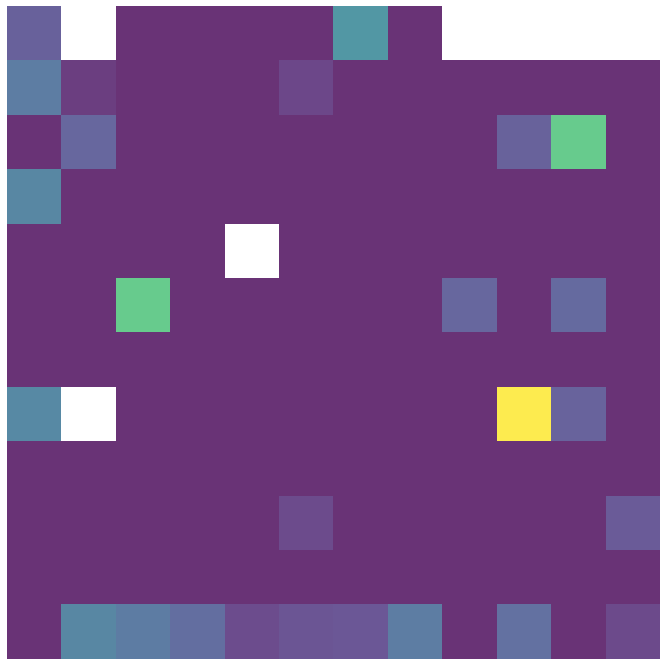

In [21]:
# plot ratemap 2d:
# np.where(is_placecell_isi)
import pylab as pl


def plot_ratemap(ratemap, axes=None, title=None, extent = [0 , 12, 0 , 12],title_color = "black", *args, **kwargs):  # pylint: disable=keyword-arg-before-vararg
    """Plot ratemaps."""
    if axes is None:
        axes = pl.gca()
    # Plot the ratemap
    axes.imshow(ratemap, interpolation='none', extent = extent, origin = "lower", alpha = 0.8, *args, **kwargs)
    # ax.pcolormesh(ratemap, *args, **kwargs)
    axes.axis('off')
    if title is not None:
        axes.set_title(title, color = title_color)

fig = plt.figure(figsize=[(12), (12)])
axes = fig.add_subplot(1, 1, 1)
# axes.invert_yaxis()

# test_maze.maze_plot_num(axes = axes, mode = "cells")
rate_map_2d = np.reshape(rate_map_all[2,], [12,12])
plot_ratemap(rate_map_2d,  axes = axes)
axes.invert_yaxis()
# plt.scatter(1,1)


In [23]:
# plot ratemap 2d:
# sorted by place cell first
sort_by_place_cell = True
directory = "img_dir"
filename = "rate_map.pdf"
# Sort by score if desired
if sort_by_place_cell:
    ordering = np.argsort(-np.array(is_placecell_isi))
else:
    ordering = range(n_neuron)
# Plot
cols = 8
rows = int(np.ceil(n_neuron / cols))
fig = plt.figure(figsize=(24, rows * 4))
for i in range(n_neuron):
    rf = plt.subplot(rows * 2, cols, i + 1)
    if i < n_neuron:
        index = ordering[i]
        title = "%d (%.2f)" % (index, SI_all[index])
        # Plot maze
        # test_maze.maze_plot(axes = axes)
        # Plot the activation maps
        if is_placecell_isi[index] == 1:
            plot_ratemap(np.reshape(rate_map_all[index,], [12,12]), axes=rf, title=title, title_color = "red")
        else:
            plot_ratemap(np.reshape(rate_map_all[index,], [12,12]), axes=rf, title=title)
        # pl.colorbar()
        rf.invert_yaxis()

if not os.path.exists(directory):
    os.makedirs(directory)
with PdfPages(os.path.join(directory, filename), "w") as f:
    plt.savefig(f, format="pdf")
    plt.close(fig)


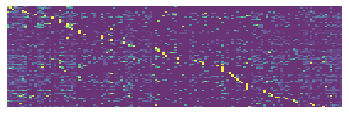

In [24]:
# plot ratemap 1d (all place cells):
sort_by_nodes = True
num_pc = int(sum(is_placecell_isi))
rate_map_pc= rate_map_all[is_placecell_isi==1,]
place_fields = np.nanargmax(rate_map_pc,axis=1)+1 # place field

if sort_by_nodes:
    ordering = np.argsort(-np.nanargmax(rate_map_pc,axis=1))
else:
    ordering = range(num_pc)

# normalize tuning curve to [0, 1]
rate_map_pc_norm = sklearn.preprocessing.minmax_scale(rate_map_pc, feature_range=(0, 1), axis=1, copy=True)
# plot
plot_ratemap(rate_map_pc_norm[ordering,:][:,~np.isnan(rate_map_pc_norm[0,])],extent = [0 , 1000, 0 , 300])
# save figure
filename = "norm_ratemap_1d.pdf"
if not os.path.exists(directory):
    os.makedirs(directory)
with PdfPages(os.path.join(directory, filename), "w") as f:
    plt.savefig(f, format="pdf")
    plt.close(fig)

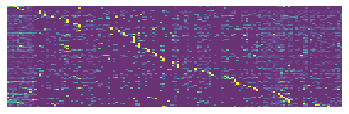

In [25]:
# ratemap 1d: orderd by shortest path
sort_by_path = True
num_pc = int(sum(is_placecell_isi))
rate_map_pc= rate_map_all[is_placecell_isi==1,]
if sort_by_path:
    non_shortest_path = list(np.setdiff1d(list(graph.keys()), test_maze.shortest_path))
    preferred_nodes = np.nanargmax(rate_map_pc,axis=1)+1 # place field
    total_list = shortest_path + non_shortest_path
    tmp_index = np.zeros(num_pc)
    for i in range(num_pc):
        tmp_index[i] =  np.where(total_list == preferred_nodes[i])[0]
        
    ordering = np.argsort(-tmp_index)
else:
    ordering = range(num_pc)

# normalize tuning curve to [0, 1]
rate_map_pc_norm = sklearn.preprocessing.minmax_scale(rate_map_pc, feature_range=(0, 1), axis=1, copy=True)
# plot
rate_map_ordered = rate_map_pc_norm[ordering,:][:,np.array(total_list)-1]
plot_ratemap(rate_map_ordered[:,~np.isnan(rate_map_ordered[0,])],extent = [0 , 1000, 0 , 300])
# save figure
filename = "norm_ratemap_1d_path.pdf"
if not os.path.exists(directory):
    os.makedirs(directory)
with PdfPages(os.path.join(directory, filename), "w") as f:
    plt.savefig(f, format="pdf")
    plt.close(fig)

In [26]:
# shortest path selective %
path_prefer_num = 0
for i in range(num_pc):
    if place_fields[i] in shortest_path:
        path_prefer_num += 1
        
path_ratio = path_prefer_num/num_pc
path_ratio_chance = len(shortest_path)/total_bin
print("% of place fields on shortest path： " + "{:.2f}".format(path_ratio*100) + "%\n Chance Level: " + "{:.2f}".format(path_ratio_chance*100)+"%" )


% of place fields on shortest path： 85.71%
 Chance Level: 77.08%


In [27]:
# decision node selective %
decision_prefer_num = 0
for i in range(num_pc):
    if place_fields[i] in test_maze.decision_nodes:
        decision_prefer_num += 1
        
decision_ratio = decision_prefer_num/num_pc
decision_ratio_chance = len(test_maze.decision_nodes)/total_bin
print("% of place fields on decison nodes： " + "{:.2f}".format(decision_ratio*100) + "%\n Chance Level: " + "{:.2f}".format(decision_ratio_chance*100)+"%" )


% of place fields on decison nodes： 11.69%
 Chance Level: 11.81%


In [71]:
# branch selective %
## spike node to runs
def node_to_run(node, runs):
    # transform node number (start from 1) to run number (start from 1)
    # for example node 1, to run 1
    run_ind = 0
    for run_i in runs:
        if node in run_i:
            run_ind = runs.index(run_i)+1
            return run_ind
    return run_ind
        
spike_runs = np.zeros_like(spike_nodes)
for i in range(len(spike_nodes)):
    spike_runs[i] = node_to_run(spike_nodes[i], test_maze.runs)


# occupancy map, in ms
_nruns = len(test_maze.runs)
_coords_range = [0, _nruns +0.0001 ]
occu_time_run, _, run_numbers = scipy.stats.binned_statistic(
        spike_runs,
        stay_time,
        bins=_nruns,
        statistic="sum",
        range=_coords_range)
assert((run_numbers == spike_runs).all())
minimum_occu_thres = 50 # ms, occupancy time less than the threshold are set to NAN, preventing large spike rate
occu_time_run[occu_time_run<minimum_occu_thres] = np.nan

# branch rate map 
### sum rate map (for first neuron)
spikes = Spikes[0,:]
# spike_map: total spikes per nodes
spike_freq_run, xbin_edges, run_numbers = scipy.stats.binned_statistic(
        spike_runs,
        spikes,
        bins=_nruns,
        statistic="sum",
        range=_coords_range)
rate_map_run = spike_freq_run/(occu_time_run/1000+ 1E-6) # ratemap: spike_map / occupancy_map
assert((run_numbers == spike_runs).all())

# rate map for branches (for all neuron)
n_neuron = Spikes.shape[0]
spike_freq_run_all = np.zeros([n_neuron, _nruns])
rate_map_run_all =  np.zeros_like(spike_freq_run_all)
for i in range(n_neuron):
    spike_freq_run_all[i,] ,_ ,_= scipy.stats.binned_statistic(
        spike_runs,
        Spikes[i,:],
        bins=_nruns,
        statistic="sum",
        range=_coords_range)
    rate_map_run_all[i,] = spike_freq_run_all[i,]/(occu_time_run/1000+ 1E-9)

In [29]:
# spatial information for runs(all neurons)
t_runs_frac = occu_time_run/1000/ (t_total+ 1E-6)   # time spent in ith bin/total session time

# Shuffle ISI: DOI: 10.1523/JNEUROSCI.19-21-09497.1999
SI_run_all = np.zeros(n_neuron)
is_runcell_isi = np.zeros(n_neuron)

for i in tqdm(range(n_neuron)):
    SI_run_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_run_all[i,], t_total=t_total, t_nodes_frac=t_runs_frac)
    is_runcell_isi[i] = shuffle_test(SI = SI_run_all[i], spikes = Spikes[i,], spike_nodes=spike_runs, occu_time=occu_time_run, _coords_range=_coords_range, _nbins = _nruns)
    
print("# of run cell using time isi shuffle method:", np.sum(is_runcell_isi ))


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:51<00:00,  1.66it/s]

# of run cell using time isi shuffle method: 79.0


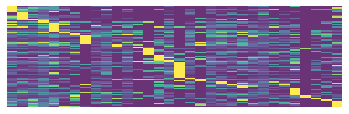

In [30]:
# plot ratemap 1d (all run cells):
sort_by_nodes = True
num_rc = int(sum(is_runcell_isi))
rate_map_rc= rate_map_run_all[is_runcell_isi==1,]
run_fields = np.nanargmax(rate_map_rc,axis=1) # run field

if sort_by_nodes:
    ordering = np.argsort(-np.nanargmax(rate_map_rc,axis=1))
else:
    ordering = range(num_rc)

# normalize tuning curve to [0, 1]
rate_map_rc_norm = sklearn.preprocessing.minmax_scale(rate_map_rc, feature_range=(0, 1), axis=1, copy=True)
# plot
plot_ratemap(rate_map_rc_norm[ordering,:][:,~np.isnan(rate_map_rc_norm[0,])],extent = [0 , 1000, 0 , 300])
# save figure
filename = "norm_ratemap_run_1d.pdf"
if not os.path.exists(directory):
    os.makedirs(directory)
with PdfPages(os.path.join(directory, filename), "w") as f:
    plt.savefig(f, format="pdf")
    plt.close(fig)

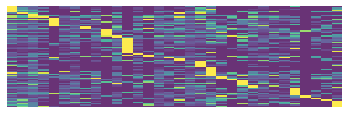

In [31]:
# run ratemap 1d: orderd by shortest path
sort_by_path = True
num_rc = int(sum(is_runcell_isi))
rate_map_rc= rate_map_run_all[is_runcell_isi==1,]
run_fields = np.nanargmax(rate_map_rc,axis=1) # place field
run_ind = np.arange(len(test_maze.runs))

if sort_by_path:
    run_on_path = [test_maze.runs[i_run][0] in test_maze.shortest_path for i_run in range(_nruns)]
    on_path_runs = run_ind[run_on_path]
    non_shortest_path = list(np.setdiff1d(list(run_ind),on_path_runs))
    preferred_runs = np.nanargmax(rate_map_rc,axis=1) # run field
    total_list = list(on_path_runs) + non_shortest_path
    tmp_index = np.zeros(num_rc)
    for i in range(num_rc):
        tmp_index[i] =  np.where(total_list == preferred_runs[i])[0]
        
    ordering = np.argsort(-tmp_index)
else:
    ordering = range(num_rc)

# normalize tuning curve to [0, 1]
rate_map_rc_norm = sklearn.preprocessing.minmax_scale(rate_map_rc, feature_range=(0, 1), axis=1, copy=True)
# plot
rate_map_rc_ordered = rate_map_rc_norm[ordering,:][:,np.array(total_list)]
plot_ratemap(rate_map_rc_ordered[:,~np.isnan(rate_map_rc_ordered[0,])],extent = [0 , 1000, 0 , 300])
# save figure
filename = "norm_ratemap_run_1d_path.pdf"
if not os.path.exists(directory):
    os.makedirs(directory)
with PdfPages(os.path.join(directory, filename), "w") as f:
    plt.savefig(f, format="pdf")
    plt.close(fig)

In [35]:
# percent of run filed on shortest path

num_shortpath_runfield = np.sum([preferred_run in on_path_runs for preferred_run in preferred_runs])
run_path_ratio = num_shortpath_runfield/num_rc
run_path_ratio_chance = np.sum(run_on_path)/len(test_maze.runs)
print("% of run fields on shortest path： " + "{:.2f}".format(run_path_ratio*100) + "%\n Chance Level: " + "{:.2f}".format(run_path_ratio_chance*100)+"%" )


% of run fields on shortest path： 54.43%
 Chance Level: 51.43%


In [33]:
run_ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [82]:
SI_rand = np.zeros(shuffle_n)
t_total = np.nansum(occu_time)/1000
t_nodes_frac = occu_time/1000/ (t_total+ 1E-6) 
spike_ind = np.where(spikes==1)[0] # spike index
isi = np.append(spike_ind[0], np.ediff1d(spike_ind)) # get interspike interval
for i in range(shuffle_n):
    shuffle_isi = np.random.choice(isi, size = len(isi), replace = False) # shuffle interspike interval
    shuffle_spike_ind = np.cumsum(shuffle_isi) # shuffled spike index

    spikes_rand = np.zeros_like(spikes)        
    spikes_rand[shuffle_spike_ind] = 1
    spike_freq_rand, _, _ = scipy.stats.binned_statistic(
        spike_nodes,
        spikes_rand,
        bins=_nbins,
        statistic="sum",
        range=_coords_range)
    rate_map_rand = spike_freq_rand/(occu_time/1000+ 1E-6)    
    SI_rand[i] = calc_SI(spikes = spikes_rand, rate_map = rate_map_rand, t_total = t_total, t_nodes_frac=t_nodes_frac)
is_placecell = SI > np.percentile(SI_rand, 95)


In [143]:
ordering

array([24, 15,  7,  8, 19, 10, 20,  9, 21,  1, 16, 12, 13,  6,  5,  3,  2,
       18, 22, 11,  4, 23, 14, 17,  0], dtype=int64)

In [62]:
isi_before_shuffle

array([  5,   9,   2,   2, 149,   3,  89,   1,  40,  34,  44,   3,   1,
         4,   1,   2,   3,   1,   2, 180,  86,   1,   8,   1,   1,  41,
        19,   2,   1,   2,   3,   1,   4,   7,  17,  40,   1,   1,  24,
       141,   1,   1,   1,   2,   1,  18,   3,   1,  41,   4,  13,  28,
         1,   1,   2,   4,  13,  17,  14, 398,  14,  25,   1,   1,   2,
        21,   6,  34,   1,   3,   4,  13,   2,   1,   6,  32,   4, 157,
        25,   3,  46,   4,   1,  19,  26,   1,   9,  30,  13,  18, 465,
         4,   1,   8,   5,   7,  35,  15,   1,  10,   2,  10,  16,   2,
         6,   1,   4,   4,   6,  39,  45,  10,   6,   2,  55,   1,   7,
         8,   1,   6,   2,  42,   5,  15,   5,  59,   1,   1,   2,  38,
         1,  20,   1,  12,  76,  14,   1,   1,   1,   2,  12,   2,   1,
         8,   2,  10,  27,   1,  15,   8,   1,   3,  10,   3,   1,   4,
         1,  12,   3,   2,   9,   2,   7,   3,  20,  71,   2,  67,   1,
        28,  46,   1,   1,   2,   4, 248,  30,   2,   3,  50,  8

In [154]:
 np.where(total_list == preferred_nodes[0])[0]

array([6], dtype=int64)

In [155]:
total_list

[1,
 13,
 14,
 26,
 27,
 15,
 3,
 4,
 5,
 6,
 18,
 17,
 29,
 30,
 31,
 19,
 20,
 21,
 9,
 10,
 11,
 12,
 24,
 23,
 22,
 34,
 33,
 32,
 44,
 45,
 46,
 47,
 48,
 60,
 59,
 58,
 57,
 56,
 68,
 69,
 70,
 71,
 72,
 84,
 83,
 95,
 94,
 82,
 81,
 80,
 92,
 104,
 103,
 91,
 90,
 78,
 79,
 67,
 55,
 54,
 66,
 65,
 64,
 63,
 75,
 74,
 62,
 50,
 51,
 39,
 38,
 37,
 49,
 61,
 73,
 85,
 97,
 109,
 110,
 122,
 123,
 111,
 112,
 100,
 99,
 87,
 88,
 76,
 77,
 89,
 101,
 102,
 114,
 113,
 125,
 124,
 136,
 137,
 138,
 126,
 127,
 115,
 116,
 117,
 129,
 141,
 142,
 130,
 131,
 132,
 144,
 2,
 7,
 8,
 16,
 25,
 28,
 35,
 36,
 40,
 41,
 42,
 43,
 52,
 53,
 86,
 93,
 96,
 98,
 105,
 106,
 107,
 108,
 118,
 119,
 120,
 121,
 128,
 133,
 134,
 135,
 139,
 140,
 143]

In [65]:
isi_before_shuffle = isi
shuffle_isi = np.random.shuffle(isi_before_shuffle) # shuffle interspike interval
shuffle_isi

In [88]:
tes = [1,2,3]
tes.index(1,2)

ValueError: 1 is not in list

In [72]:
shuffle_spike_ind = np.cumsum(shuffle_isi)
shuffle_spike_ind

array([None], dtype=object)

In [76]:
tmp = isi
shuffle_isi = np.random.shuffle(tmp) # shuffle interspike interval
shuffle_spike_ind = np.cumsum(shuffle_isi) # shuffled spike index
shuffle_spike_ind

array([None], dtype=object)

In [162]:
DeconvSignal_behav.shape

(85, 7188)

In [78]:
arr =isi 
np.random.shuffle(arr)
np.cumsum(arr)

array([   5,   20,   32,   33,   34,   36,   86,   88,   89,  115,  116,
        120,  138,  139,  142,  145,  147,  209,  210,  213,  225,  271,
        279,  281,  287,  289,  293,  299,  300,  303,  306,  358,  374,
        378,  379,  380,  383,  385,  395,  409,  414,  415,  455,  708,
        718,  719,  923,  977, 1039, 1180, 1181, 1194, 1197, 1198, 1199,
       1200, 1201, 1203, 1204, 1290, 1291, 1299, 1375, 1376, 1378, 1419,
       1422, 1511, 1556, 1699, 1700, 1731, 1732, 1737, 1886, 1887, 1905,
       1907, 1911, 2309, 2351, 2599, 2612, 2655, 2663, 2665, 2697, 2698,
       2728, 2783, 2808, 2847, 3013, 3016, 3034, 3038, 3048, 3051, 3055,
       3072, 3078, 3080, 3081, 3084, 3103, 3104, 3105, 3137, 3208, 3242,
       3250, 3251, 3338, 3339, 3360, 3361, 3363, 3589, 3590, 4055, 4059,
       4062, 4067, 4068, 4114, 4172, 4174, 4175, 4177, 4178, 4193, 4194,
       4196, 4208, 4222, 4225, 4232, 4234, 4235, 4236, 4274, 4298, 4302,
       4330, 4333, 4334, 4335, 4338, 4340, 4341, 43

In [244]:
test_maze.run_levels

[0,
 0,
 1,
 2,
 2,
 3,
 3,
 4,
 5,
 6,
 7,
 8,
 8,
 9,
 9,
 10,
 11,
 11,
 12,
 12,
 13,
 14,
 14,
 15,
 16,
 16,
 16,
 15,
 13,
 10,
 7,
 6,
 5,
 4,
 1]

In [80]:
arr

array([  5,  15,  12,   1,   1,   2,  50,   2,   1,  26,   1,   4,  18,
         1,   3,   3,   2,  62,   1,   3,  12,  46,   8,   2,   6,   2,
         4,   6,   1,   3,   3,  52,  16,   4,   1,   1,   3,   2,  10,
        14,   5,   1,  40, 253,  10,   1, 204,  54,  62, 141,   1,  13,
         3,   1,   1,   1,   1,   2,   1,  86,   1,   8,  76,   1,   2,
        41,   3,  89,  45, 143,   1,  31,   1,   5, 149,   1,  18,   2,
         4, 398,  42, 248,  13,  43,   8,   2,  32,   1,  30,  55,  25,
        39, 166,   3,  18,   4,  10,   3,   4,  17,   6,   2,   1,   3,
        19,   1,   1,  32,  71,  34,   8,   1,  87,   1,  21,   1,   2,
       226,   1, 465,   4,   3,   5,   1,  46,  58,   2,   1,   2,   1,
        15,   1,   2,  12,  14,   3,   7,   2,   1,   1,  38,  24,   4,
        28,   3,   1,   1,   3,   2,   1,   5,   4,   1,   1,   5,  10,
        40,  10,  18,   4,   5,  59,   1,   2,  15,   3,   4,   1,  59,
         3,  49,   7,  28, 319,   6,   4,   4,   1,   2,   6,  4

In [237]:
occu_time, xbin_edges, bin_numbers = scipy.stats.binned_statistic(
        spike_nodes,
        stay_time,
        bins=_nbins,
        statistic="sum",
        range=_coords_range)


In [261]:
np.nanargmax(rate_map_pc,axis=1)

array([  2,  62,  38,  38,  26,  53,  49, 124, 125,  88, 103,  24,  81,
        65,   8, 121,  44,   1,  29, 112, 100,  98,  25,   7, 124],
      dtype=int64)

In [4]:
DeconvSignal_behav.shape

(85, 7188)

In [10]:
np.std(DeconvSignal_behav, axis = 1).shape

(85,)

In [12]:
deconv_sd = np.std(DeconvSignal_behav, axis = 1)
tmp = np.where(DeconvSignal_behav>deconv_sd, 1, 0)


ValueError: operands could not be broadcast together with shapes (85,7188) (85,) 

In [27]:
x = np.array([1,2,3])

np.repeat(x[:,np.newaxis], 3, 1)


array([[1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3]])

In [20]:
np.repeat(x[np.newaxis,:], 3, 0)


array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [21]:
?np.repeat

In [22]:
x[:,np.newaxis].shape

(3, 1)

In [23]:
x.shape

(3,)

In [30]:
np.repeat(deconv_sd[:,np.newaxis], Spikes.shape[1],1)

array([[0.02039383, 0.02039383, 0.02039383, ..., 0.02039383, 0.02039383,
        0.02039383],
       [0.01646271, 0.01646271, 0.01646271, ..., 0.01646271, 0.01646271,
        0.01646271],
       [0.0312843 , 0.0312843 , 0.0312843 , ..., 0.0312843 , 0.0312843 ,
        0.0312843 ],
       ...,
       [0.00335755, 0.00335755, 0.00335755, ..., 0.00335755, 0.00335755,
        0.00335755],
       [0.00980338, 0.00980338, 0.00980338, ..., 0.00980338, 0.00980338,
        0.00980338],
       [0.00695207, 0.00695207, 0.00695207, ..., 0.00695207, 0.00695207,
        0.00695207]])

In [29]:
Spikes.shape[1]

7188

In [116]:
preferred_nodes

array([  3,  63,  39,  39,  27,  54,  50, 125, 126,  89, 104,  25,  82,
        66,   9, 122,  45,   2,  30, 113, 101,  99,  26,   8, 125],
      dtype=int64)

In [263]:
np.nanargmax(rate_map_rc,axis=1)

array([16, 24, 16, 16,  1, 16, 29,  4, 13, 34, 15, 23, 16, 34,  3, 16, 12,
       32, 30,  6, 29, 16,  7,  1,  4,  7, 16, 16, 16,  0,  1,  0,  0, 13,
       34], dtype=int64)

In [268]:
rate_map_rc

array([[ 0.48651654,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06950236,  0.16001707,  0.        , ...,  0.        ,
         1.33244504,  0.        ],
       [ 0.        ,  0.05333902,  0.20684662, ...,  0.        ,
         0.        ,  4.63535229],
       ...,
       [ 3.75312761,  2.45359505,  1.55134967, ...,  0.        ,
         0.        ,  1.54511743],
       [ 1.04253545,  1.38681459,  0.51711656, ...,  1.87734668,
         0.66622252,  0.92707046],
       [ 0.62552127,  0.        ,  8.48071155, ...,  0.        ,
         0.        , 11.43386897]])

In [262]:
rate_map_rc

array([[ 0.48651654,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06950236,  0.16001707,  0.        , ...,  0.        ,
         1.33244504,  0.        ],
       [ 0.        ,  0.05333902,  0.20684662, ...,  0.        ,
         0.        ,  4.63535229],
       ...,
       [ 3.75312761,  2.45359505,  1.55134967, ...,  0.        ,
         0.        ,  1.54511743],
       [ 1.04253545,  1.38681459,  0.51711656, ...,  1.87734668,
         0.66622252,  0.92707046],
       [ 0.62552127,  0.        ,  8.48071155, ...,  0.        ,
         0.        , 11.43386897]])

In [36]:
SI_run_all

array([1.49498733, 2.68210212, 1.21811104, 1.27613649, 1.51165436,
       0.95051293, 3.32332848, 1.42778632, 0.88717287, 1.36169775,
       0.64141668, 0.92343219, 0.71061013, 1.63099632, 0.62419204,
       0.80457631, 1.26611799, 2.46820331, 1.61374397, 0.80857087,
       0.37737995, 0.89251782, 0.51984037, 0.54127781, 0.38517056,
       0.49234618, 0.41793509, 0.51396556, 0.7304565 , 0.45752368,
       0.72471165, 0.68850056, 0.51787696, 0.42084189, 0.41336001,
       0.29285347, 0.74033092, 0.53754752, 0.41876977, 0.41784021,
       0.6797544 , 0.61273766, 0.48301148, 0.59727022, 0.52604189,
       0.27478439, 0.42116694, 0.29617716, 0.58270066, 0.18197712,
       0.375214  , 0.20759095, 0.56075143, 0.37961457, 0.45162183,
       0.33521714, 0.31601146, 0.35404595, 0.18773484, 1.43080486,
       0.19953204, 0.37677123, 0.20991828, 0.31443514, 0.69971348,
       0.39118486, 0.29961375, 0.28904078, 0.23196357, 0.31444214,
       0.25445247, 0.3023009 , 0.16158974, 0.28847575, 0.44621

In [5]:
n_neuron

NameError: name 'n_neuron' is not defined

In [37]:
occu_time

array([14388., 18748.,  4971.,  3336.,  4569.,  8410.,  4253.,  2134.,
         233.,  1001.,   501.,   466.,  9669.,  6664.,  2935.,  1001.,
        1064.,  2037.,   167.,  2201.,   967.,   667.,   668.,  1337.,
        3236.,  2203.,  4301.,  1701.,   534.,   267.,   933.,   567.,
         567.,   500.,   533.,  1065.,   867.,   567.,   833.,    nan,
          nan,  1501.,   934.,   673.,   267.,   633.,   567.,   735.,
         567.,   534.,  4269.,  2101.,  1268.,   486.,   768.,   600.,
         343.,   967.,   734.,  1367.,  5200.,   467.,   500.,   300.,
         434.,   433.,   335.,   567.,   334.,   333.,   601.,   133.,
         401.,   301.,   400.,    51.,  1468.,   467.,   399.,   501.,
         465.,   368.,   500.,   601.,   299.,    nan,   534.,   567.,
         533.,   167.,   401.,   333.,    nan,   968.,    66.,    nan,
         334.,    nan,   100.,   767.,   501.,   233.,   633.,   134.,
          nan,   199.,  1468.,  1200.,   802.,  1199.,    nan,  1100.,
      

In [39]:
max(spike_runs)

35

In [42]:
spike_runs = np.zeros_like(spike_nodes)
for i in range(len(spike_nodes)):
    spike_runs[i] = [run_i for run_i, run in enumerate(test_maze.runs) if spike_nodes[i] in run][0] +1


NameError: name 'run_i' is not defined

In [47]:
test_maze.runs.index(test_maze.runs[0])

0

In [48]:
def node_to_run(node, runs):
    # transform node number (start from 1) to run number (start from 1)
    # for example node 1, to run 1
    run_ind = 0
    for run_i in runs:
        if node in run_i:
            run_ind = runs.index(run_i) +1
            return run_ind
    return run_ind
        

In [51]:
# run selective %
## spike node to runs
def node_to_run(node, runs):
    # transform node number (start from 1) to run number (start from 1)
    # for example node 1, to run 1
    run_ind = 0
    for run_i in runs:
        if node in run_i:
            run_ind = runs.index(run_i)+1
            return run_ind
    return run_ind
        
spike_runs = np.zeros_like(spike_nodes)
for i in range(len(spike_nodes)):
    spike_runs[i] = node_to_run(spike_nodes[i], test_maze.runs)



In [65]:
spike_nodes[850]

25

In [63]:
node_to_run(spike_nodes[851], test_maze.runs)

3

In [67]:
len(test_maze.runs)

35

In [68]:
test_maze.runs

[[1],
 [2],
 [13],
 [14, 26, 27, 15, 3, 4, 5, 6],
 [7, 8],
 [18, 17],
 [16, 28],
 [29, 30],
 [31, 19, 20, 21, 9, 10, 11, 12, 24],
 [23,
  22,
  34,
  33,
  32,
  44,
  45,
  46,
  47,
  48,
  60,
  59,
  58,
  57,
  56,
  68,
  69,
  70,
  71,
  72,
  84],
 [83, 95, 94],
 [82, 81, 80, 92, 104, 103, 91, 90, 78, 79, 67, 55],
 [43],
 [54],
 [53],
 [66, 65, 64, 63, 75, 74, 62, 50, 51],
 [39],
 [40],
 [38, 37, 49, 61, 73, 85, 97],
 [98, 86],
 [109],
 [110,
  122,
  123,
  111,
  112,
  100,
  99,
  87,
  88,
  76,
  77,
  89,
  101,
  102,
  114,
  113,
  125,
  124,
  136,
  137,
  138,
  126,
  127,
  115,
  116,
  117,
  129],
 [128, 140, 139],
 [141, 142],
 [130],
 [118, 119, 107, 108, 120],
 [131, 132, 144],
 [143],
 [121, 133, 134, 135],
 [52],
 [106, 105, 93],
 [96],
 [36, 35],
 [42, 41],
 [25]]

In [69]:
_nruns = len(test_maze.runs)
_coords_range = [0, _nruns +0.0001 ]
occu_time_run, _, run_numbers = scipy.stats.binned_statistic(
        spike_runs,
        stay_time,
        bins=_nruns,
        statistic="sum",
        range=_coords_range)
assert((run_numbers == spike_runs).all())
minimum_occu_thres = 50 # ms, occupancy time less than the threshold are set to NAN, preventing large spike rate
occu_time_run[occu_time_run<minimum_occu_thres] = np.nan


In [70]:
occu_time_run.shape

(35,)

In [72]:
rate_map_run_all.shape

(85, 35)

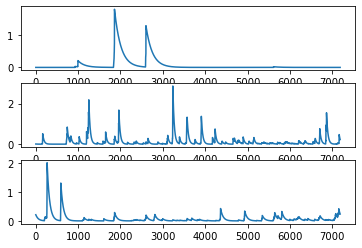

In [74]:
plt.subplot(311)
plt.plot(FiltTraces_behav[1,:])
plt.subplot(312)
plt.plot(FiltTraces_behav[2,:])
plt.subplot(313)
plt.plot(FiltTraces_behav[3,:])

In [4]:
test

[150.295,
 90.473,
 0.6242316254651781,
 0.5079365079365079,
 array([33088., 12688., 43584.,  5728.,  2207., 10016., 12592.,  1584.,
         5825.,  1760.,  9738.,   870.,  8208.,  7552., 23632.,  7440.,
        54256.])]

In [9]:
ms_mat

<Closed HDF5 group>

In [25]:
spike_times.shape

(85,)

In [14]:
?spike_times.

In [6]:
spike_nodes

array([  1,   1,   1, ..., 144, 144, 144])

In [7]:
spike_bins

(array([ 0,  0,  0, ..., 11, 11, 11], dtype=int32),
 array([ 0,  0,  0, ..., 11, 11, 11], dtype=int32))

In [13]:
occu_time

array([ 4837.,    nan,    67.,   802.,  1000.,   967.,  1268.,  2784.,
          nan,    nan,    nan,    nan,  8304.,  6970.,  2868.,  2533.,
        1767.,  3702.,  2271.,  2368.,   337.,   659.,   600.,   867.,
        1820.,  8304.,  1700.,   466.,  1301.,  1200.,   567.,   433.,
         400.,  1573.,  2336.,  3968.,  3134.,  4195.,  4906.,   801.,
         467.,   902.,   500.,  1834.,  1568.,   634.,   434.,   100.,
        1334.,  2200.,  3134.,   967.,    nan,   671.,  1665.,  1531.,
        1042.,  1066.,  1168.,  1367.,   868.,  1571.,  2334.,  1368.,
        1723.,   997.,   570.,  2102.,  1403.,  1533.,  1301.,   867.,
         699.,   664.,   768.,   768.,  1100.,   430.,   966.,  1201.,
         933.,   734.,   749.,  1335.,   768.,    nan,   433.,  1302.,
        3402.,   835.,   301.,   534.,   501.,  1902.,  3070.,  1132.,
         935.,   200.,  1405.,  1595.,  3100.,   834.,   595.,   637.,
         932.,  1038.,   859.,   467.,  1366.,  8367.,   734.,  1471.,
      

In [14]:
spike_nodes

array([  1,   1,   1, ..., 144, 144, 144])

In [18]:
spikes

array([0, 0, 0, ..., 0, 0, 0])